In [1]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm

# Helper functions

In [2]:
def plot_hist(returns, zeta=0.05, alpha=0.05, q):
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    qtl = np.quantile(returns, 1-q)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.title(f'$\\zeta$ = {zeta}, $\\alpha$={alpha}, q={q}')
    plt.axvline(var, c='y', linestyle='--', label=f'$VaR={var:4.4}$')
    plt.axvline(cvar, c='r', linestyle='--', label=f'$CVaR={cvar:4.4}$')
    plt.axvline(zeta, c='g', linestyle='--', label=f'$P(r\geq{zeta:.4})={p}$')
    plt.axvline(qtl, c='m', linestyle='--', label=f'$P(r\geq{qtl:.4})={q:.4}$')
    plt.legend()

# Parameters

In [69]:
N_pools = 6
params = {'N_pools': N_pools,
          'Rx0': 100 * np.ones(N_pools),
          'Ry0': 1000 * np.ones(N_pools),
          'phi': 0.03 * np.ones(N_pools),
          'x_0': 10,
          'alpha': 0.1,
          'q': 0.8,
          'zeta': 0.05,
          'batch_size': 1_000,
          'kappa': np.array([0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
          'sigma': np.array([1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]),
          'p': np.array([0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]),
          'T': 60,
          'seed': 4294967143}

locals().update(params)

## Initial Conditions

In [81]:
x_0 = 40
zero = 1e-4
xs_0 = np.repeat(x_0/N_pools, N_pools)
relo = np.vectorize(lambda x: np.max([x, zero]))

In [86]:
# convergence parameters:
epochs = 6

## Simulation

In [87]:
norm_difference = 1
weights_over_time = [np.repeat(1/N_pools, N_pools)]

for i in range(epochs):
    
    #initialise the pools and mint liquidity tokens
    pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)
    l = pools.swap_and_mint(xs_0)

    # generate returns
    np.random.seed(seed)
    end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)
    
    x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
    log_ret = np.log(x_T/xs_0)
    
    # optimise
    N_returns, N_assets = log_ret.shape

    weights = cp.Variable((N_assets,))
    X = log_ret @ weights

    Z = cp.Variable((N_returns,))
    var = cp.Variable((1,))
    cvar = var + 1 / (alpha * N_returns) * cp.sum(Z)

    constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]

    # CVaR constraints
    constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

    # lower bound: average of emp cdf:
    # might not be a valid constraint!
    emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
    constraints += [emp_cdf_005 @ weights * 1000 >= q * 1000]

    objective = cp.Minimize(cvar * 1000)
    
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver="ECOS")
    
    # extract optimisation result
    weights_over_time.append(weights.value)
    xs_0 = relo(x_0 * weights.value)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.80it/s]


## Visualising results

In [88]:
pd.DataFrame(weights_over_time)

,0,1,2,3,4,5
0,0.166667,0.166667,1.666667e-01,0.166667,0.166667,1.666667e-01
1,0.808862,0.137069,3.379044e-15,0.044809,0.009260,-6.298267e-16
2,0.818048,0.130981,1.078463e-13,0.042775,0.008196,-1.593457e-14
3,0.843056,0.119519,5.633773e-15,0.032641,0.004784,-3.309089e-14
4,0.847168,0.118899,-7.809879e-16,0.029070,0.004864,-3.420255e-15
5,0.847248,0.118743,-1.208134e-15,0.029154,0.004855,-6.129727e-15
6,0.847252,0.118734,-1.144139e-15,0.029159,0.004855,-5.868786e-15


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.97it/s]


array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

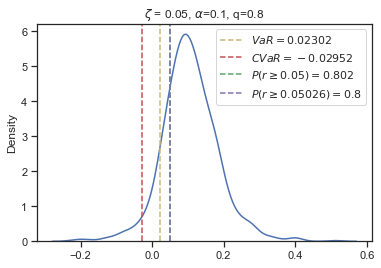

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.37it/s]


array([ 8.08861992e-01,  1.37068647e-01,  3.37904438e-15,  4.48094145e-02,
        9.25994704e-03, -6.29826703e-16])

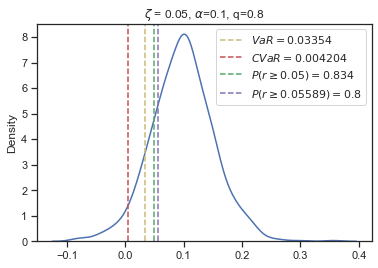

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.78it/s]


array([ 8.18048368e-01,  1.30980673e-01,  1.07846325e-13,  4.27753889e-02,
        8.19556984e-03, -1.59345730e-14])

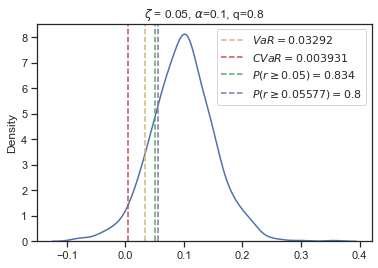

 34%|██████████████████████████▋                                                   | 342/1000 [00:02<00:04, 136.43it/s]

In [ ]:
# visualise results of weights
for weights in weights_over_time:
    xs_0 = relo(x_0 * weights)
    pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)
    l = pools.swap_and_mint(xs_0)

    # generate returns
    np.random.seed(seed)
    end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)
    
    x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
    log_ret = np.log(x_T/xs_0)
    portfolio_returns = log_ret @ weights
    display(weights)
    plot_hist(portfolio_returns, zeta=zeta, alpha=alpha, q=q)
    plt.show()

,0,1,2,3,4,5
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.612785,0.227794,0.035103,0.095061,0.022119,0.007139
2,0.630733,0.227394,0.036176,0.082034,0.020562,0.003100
3,0.629077,0.231181,0.032459,0.084006,0.020495,0.002783
